# Module 3: Assignment B #

------

## 1. Dynamic Progamming Implementation

Implement dynamic programming algorithms for global ([Needleman-Wunsch](https://pubmed.ncbi.nlm.nih.gov/5420325/)) and local ([Smith-Waterman](https://pubmed.ncbi.nlm.nih.gov/7265238)) alignment of protein sequences. The implementation should be a stand alone, command-line application. 


> There is a jupyter notebook in the module that walkthrough a partial implemention of Needleman-Wunsch. Feel free to use this code as a starter, but you do not feel obligated to. You may find it easier to start from scratch so that you can completely understand every aspect of your code or use this to get you started. There are some differences of what is being asked of you here, as to what is implemented (eg. scoring matrix, protein only) in the notebook.

The application should allow the user to read in the sequences from a fasta formatted file, select the type of alignment (local or global).

The application should take parameter from the the command line to set the sequence files, the type of alignment, the scoring matrix and a linear gap penalty. Include the ability to select either the blosum62 or pam250 scoring matrices. The matrices are included as python dictionaries [here]().

An example of running the program is shown below:

```

align.py --seq1 sequence_file.fasta \
         --seq2 different_sequence_file.fasta \ 
         --type global \
         --matrix blosum62 \
         --gap_penalty -2

```

Please use judicious comments throughout your code. 

The program should report the alignment score, the sequence identity and a visual representation of the alignment. For example:

```

seq 1   GCTAGGATAGGCAATTGGCCTAG--T--G
seq 2   ------ATA-GTAATTGGCCT-GCTTGAG
Aligment Score:    3
Sequence Identity: 78%

```

Implement your code in a seperate module and provide an example of a command used to test it, along with the corresponding files.

In [1]:
import numpy as np
import argparse
import matplotlib.pyplot as plt
import scipy.stats
import time

In [2]:
PAM250 = {
'A': {'A': 2,  'C': -2, 'D':  0, 'E': 0, 'F': -3, 'G':  1, 'H': -1, 'I': -1, 'K': -1, 'L': -2, 'M': -1, 'N':  0, 'P':  1, 'Q':  0, 'R': -2, 'S':  1, 'T':  1, 'V':  0, 'W': -6, 'Y': -3},
'C': {'A': -2, 'C': 12, 'D': -5, 'E':-5, 'F': -4, 'G': -3, 'H': -3, 'I': -2, 'K': -5, 'L': -6, 'M': -5, 'N': -4, 'P': -3, 'Q': -5, 'R': -4, 'S':  0, 'T': -2, 'V': -2, 'W': -8, 'Y':  0},
'D': {'A': 0,  'C': -5, 'D':  4, 'E': 3, 'F': -6, 'G':  1, 'H':  1, 'I': -2, 'K':  0, 'L': -4, 'M': -3, 'N':  2, 'P': -1, 'Q':  2, 'R': -1, 'S':  0, 'T':  0, 'V': -2, 'W': -7, 'Y': -4},
'E': {'A': 0,  'C': -5, 'D':  3, 'E': 4, 'F': -5, 'G':  0, 'H':  1, 'I': -2, 'K':  0, 'L': -3, 'M': -2, 'N':  1, 'P': -1, 'Q':  2, 'R': -1, 'S':  0, 'T':  0, 'V': -2, 'W': -7, 'Y': -4},
'F': {'A': -3, 'C': -4, 'D': -6, 'E':-5, 'F':  9, 'G': -5, 'H': -2, 'I':  1, 'K': -5, 'L':  2, 'M':  0, 'N': -3, 'P': -5, 'Q': -5, 'R': -4, 'S': -3, 'T': -3, 'V': -1, 'W':  0, 'Y':  7},
'G': {'A': 1,  'C': -3, 'D':  1, 'E': 0, 'F': -5, 'G':  5, 'H': -2, 'I': -3, 'K': -2, 'L': -4, 'M': -3, 'N':  0, 'P':  0, 'Q': -1, 'R': -3, 'S':  1, 'T':  0, 'V': -1, 'W': -7, 'Y': -5},
'H': {'A': -1, 'C': -3, 'D':  1, 'E': 1, 'F': -2, 'G': -2, 'H':  6, 'I': -2, 'K':  0, 'L': -2, 'M': -2, 'N':  2, 'P':  0, 'Q':  3, 'R':  2, 'S': -1, 'T': -1, 'V': -2, 'W': -3, 'Y':  0},
'I': {'A': -1, 'C': -2, 'D': -2, 'E':-2, 'F':  1, 'G': -3, 'H': -2, 'I':  5, 'K': -2, 'L':  2, 'M':  2, 'N': -2, 'P': -2, 'Q': -2, 'R': -2, 'S': -1, 'T':  0, 'V':  4, 'W': -5, 'Y': -1},
'K': {'A': -1, 'C': -5, 'D':  0, 'E': 0, 'F': -5, 'G': -2, 'H':  0, 'I': -2, 'K':  5, 'L': -3, 'M':  0, 'N':  1, 'P': -1, 'Q':  1, 'R':  3, 'S':  0, 'T':  0, 'V': -2, 'W': -3, 'Y': -4},
'L': {'A': -2, 'C': -6, 'D': -4, 'E':-3, 'F':  2, 'G': -4, 'H': -2, 'I':  2, 'K': -3, 'L':  6, 'M':  4, 'N': -3, 'P': -3, 'Q': -2, 'R': -3, 'S': -3, 'T': -2, 'V':  2, 'W': -2, 'Y': -1},
'M': {'A': -1, 'C': -5, 'D': -3, 'E':-2, 'F':  0, 'G': -3, 'H': -2, 'I':  2, 'K':  0, 'L':  4, 'M':  6, 'N': -2, 'P': -2, 'Q': -1, 'R':  0, 'S': -2, 'T': -1, 'V':  2, 'W': -4, 'Y': -2},
'N': {'A': 0,  'C': -4, 'D':  2, 'E': 1, 'F': -3, 'G':  0, 'H':  2, 'I': -2, 'K':  1, 'L': -3, 'M': -2, 'N':  2, 'P':  0, 'Q':  1, 'R':  0, 'S':  1, 'T':  0, 'V': -2, 'W': -4, 'Y': -2},
'P': {'A': 1,  'C': -3, 'D': -1, 'E':-1, 'F': -5, 'G':  0, 'H':  0, 'I': -2, 'K': -1, 'L': -3, 'M': -2, 'N':  0, 'P':  6, 'Q':  0, 'R':  0, 'S':  1, 'T':  0, 'V': -1, 'W': -6, 'Y': -5},
'Q': {'A': 0,  'C': -5, 'D':  2, 'E': 2, 'F': -5, 'G': -1, 'H':  3, 'I': -2, 'K':  1, 'L': -2, 'M': -1, 'N':  1, 'P':  0, 'Q':  4, 'R':  1, 'S': -1, 'T': -1, 'V': -2, 'W': -5, 'Y': -4},
'R': {'A': -2, 'C': -4, 'D': -1, 'E':-1, 'F': -4, 'G': -3, 'H':  2, 'I': -2, 'K':  3, 'L': -3, 'M':  0, 'N':  0, 'P':  0, 'Q':  1, 'R':  6, 'S':  0, 'T': -1, 'V': -2, 'W':  2, 'Y': -4},
'S': {'A': 1,  'C':  0, 'D':  0, 'E': 0, 'F': -3, 'G':  1, 'H': -1, 'I': -1, 'K':  0, 'L': -3, 'M': -2, 'N':  1, 'P':  1, 'Q': -1, 'R':  0, 'S':  2, 'T':  1, 'V': -1, 'W': -2, 'Y': -3},
'T': {'A': 1,  'C': -2, 'D':  0, 'E': 0, 'F': -3, 'G':  0, 'H': -1, 'I':  0, 'K':  0, 'L': -2, 'M': -1, 'N':  0, 'P':  0, 'Q': -1, 'R': -1, 'S':  1, 'T':  3, 'V':  0, 'W': -5, 'Y': -3},
'V': {'A': 0,  'C': -2, 'D': -2, 'E':-2, 'F': -1, 'G': -1, 'H': -2, 'I':  4, 'K': -2, 'L':  2, 'M':  2, 'N': -2, 'P': -1, 'Q': -2, 'R': -2, 'S': -1, 'T':  0, 'V':  4, 'W': -6, 'Y': -2},
'W': {'A': -6, 'C': -8, 'D': -7, 'E':-7, 'F':  0, 'G': -7, 'H': -3, 'I': -5, 'K': -3, 'L': -2, 'M': -4, 'N': -4, 'P': -6, 'Q': -5, 'R':  2, 'S': -2, 'T': -5, 'V': -6, 'W': 17, 'Y':  0},
'Y': {'A': -3, 'C':  0, 'D': -4, 'E':-4, 'F':  7, 'G': -5, 'H':  0, 'I': -1, 'K': -4, 'L': -1, 'M': -2, 'N': -2, 'P': -5, 'Q': -4, 'R': -4, 'S': -3, 'T': -3, 'V': -2, 'W':  0, 'Y': 10}}

BLOSUM62={'C':{'C':9,'S':-1,'T':-1,'P':-3,'A':0,'G':-3,'N':-3,'D':-3,'E':-4,'Q':-3,'H':-3,'R':-3,'K':-3,'M':-1,'I':-1,'L':-1,'V':-1,'F':-2,'Y':-2,'W':-2},
          'S':{'C':-1,'S':4,'T':1,'P':-1,'A':1,'G':0,'N':1,'D':0,'E':0,'Q':0,'H':-1,'R':-1,'K':0,'M':-1,'I':-2,'L':-2,'V':-2,'F':-2,'Y':-2,'W':-3},
          'T':{'C':-1,'S':1,'T':4,'P':1,'A':-1,'G':1,'N':0,'D':1,'E':0,'Q':0,'H':0,'R':-1,'K':0,'M':-1,'I':-2,'L':-2,'V':-2,'F':-2,'Y':-2,'W':-3},
          'P':{'C':-3,'S':-1,'T':1,'P':7,'A':-1,'G':-2,'N':-1,'D':-1,'E':-1,'Q':-1,'H':-2,'R':-2,'K':-1,'M':-2,'I':-3,'L':-3,'V':-2,'F':-4,'Y':-3,'W':-4},
          'A':{'C':0,'S':1,'T':-1,'P':-1,'A':4,'G':0,'N':-1,'D':-2,'E':-1,'Q':-1,'H':-2,'R':-1,'K':-1,'M':-1,'I':-1,'L':-1,'V':-2,'F':-2,'Y':-2,'W':-3},
          'G':{'C':-3,'S':0,'T':1,'P':-2,'A':0,'G':6,'N':-2,'D':-1,'E':-2,'Q':-2,'H':-2,'R':-2,'K':-2,'M':-3,'I':-4,'L':-4,'V':0,'F':-3,'Y':-3,'W':-2},
          'N':{'C':-3,'S':1,'T':0,'P':-2,'A':-2,'G':0,'N':6,'D':1,'E':0,'Q':0,'H':-1,'R':0,'K':0,'M':-2,'I':-3,'L':-3,'V':-3,'F':-3,'Y':-2,'W':-4},
          'D':{'C':-3,'S':0,'T':1,'P':-1,'A':-2,'G':-1,'N':1,'D':6,'E':2,'Q':0,'H':-1,'R':-2,'K':-1,'M':-3,'I':-3,'L':-4,'V':-3,'F':-3,'Y':-3,'W':-4},
          'E':{'C':-4,'S':0,'T':0,'P':-1,'A':-1,'G':-2,'N':0,'D':2,'E':5,'Q':2,'H':0,'R':0,'K':1,'M':-2,'I':-3,'L':-3,'V':-3,'F':-3,'Y':-2,'W':-3},
          'Q':{'C':-3,'S':0,'T':0,'P':-1,'A':-1,'G':-2,'N':0,'D':0,'E':2,'Q':5,'H':0,'R':1,'K':1,'M':0,'I':-3,'L':-2,'V':-2,'F':-3,'Y':-1,'W':-2},
          'H':{'C':-3,'S':-1,'T':0,'P':-2,'A':-2,'G':-2,'N':1,'D':1,'E':0,'Q':0,'H':8,'R':0,'K':-1,'M':-2,'I':-3,'L':-3,'V':-2,'F':-1,'Y':2,'W':-2},
          'R':{'C':-3,'S':-1,'T':-1,'P':-2,'A':-1,'G':-2,'N':0,'D':-2,'E':0,'Q':1,'H':0,'R':5,'K':2,'M':-1,'I':-3,'L':-2,'V':-3,'F':-3,'Y':-2,'W':-3},
          'K':{'C':-3,'S':0,'T':0,'P':-1,'A':-1,'G':-2,'N':0,'D':-1,'E':1,'Q':1,'H':-1,'R':2,'K':5,'M':-1,'I':-3,'L':-2,'V':-3,'F':-3,'Y':-2,'W':-3},
          'M':{'C':-1,'S':-1,'T':-1,'P':-2,'A':-1,'G':-3,'N':-2,'D':-3,'E':-2,'Q':0,'H':-2,'R':-1,'K':-1,'M':5,'I':1,'L':2,'V':-2,'F':0,'Y':-1,'W':-1},
          'I':{'C':-1,'S':-2,'T':-2,'P':-3,'A':-1,'G':-4,'N':-3,'D':-3,'E':-3,'Q':-3,'H':-3,'R':-3,'K':-3,'M':1,'I':4,'L':2,'V':1,'F':0,'Y':-1,'W':-3},
          'L':{'C':-1,'S':-2,'T':-2,'P':-3,'A':-1,'G':-4,'N':-3,'D':-4,'E':-3,'Q':-2,'H':-3,'R':-2,'K':-2,'M':2,'I':2,'L':4,'V':3,'F':0,'Y':-1,'W':-2},
          'V':{'C':-1,'S':-2,'T':-2,'P':-2,'A':0,'G':-3,'N':-3,'D':-3,'E':-2,'Q':-2,'H':-3,'R':-3,'K':-2,'M':1,'I':3,'L':1,'V':4,'F':-1,'Y':-1,'W':-3},
          'F':{'C':-2,'S':-2,'T':-2,'P':-4,'A':-2,'G':-3,'N':-3,'D':-3,'E':-3,'Q':-3,'H':-1,'R':-3,'K':-3,'M':0,'I':0,'L':0,'V':-1,'F':6,'Y':3,'W':1},
          'Y':{'C':-2,'S':-2,'T':-2,'P':-3,'A':-2,'G':-3,'N':-2,'D':-3,'E':-2,'Q':-1,'H':2,'R':-2,'K':-2,'M':-1,'I':-1,'L':-1,'V':-1,'F':3,'Y':7,'W':2},
          'W':{'C':-2,'S':-3,'T':-3,'P':-4,'A':-3,'G':-2,'N':-4,'D':-4,'E':-3,'Q':-2,'H':-2,'R':-3,'K':-3,'M':-1,'I':-3,'L':-2,'V':-3,'F':1,'Y':2,'W':11}
          }

In [3]:
def calcbest(above, diag, left, scope, matrixcost, gap):
    values = np.zeros(3)
    values[0] = above + gap
    values[1] = left + gap
    values[2] = diag + matrixcost
    highest = max(values)
    if (scope == 'local' and highest < 0):
        return 0
    return highest

In [4]:
def find_align(first, second, scope, matrix, gap):
    costs = np.zeros((1 + len(first), 1 + len(second)))
    if (scope == 'global'):
        for i in range(1, 1+len(first)):
            costs[i][0] = i * gap
        for i in range(1, 1+len(second)):
            costs[0][i] = i * gap
    for i in range(1, 1+len(first)):
        for j in range(1, 1 + len(second)):
            matrixcost = matrix[first[i-1].upper()][second[j-1].upper()]
            costs[i][j] = calcbest(costs[i-1][j], costs[i-1][j-1], costs[i][j-1], scope, matrixcost, gap)
    return costs

In [30]:
def backstep(costs, firstloc, secondloc, scope, gap):
    if (costs[firstloc][secondloc] == gap + costs[firstloc - 1][secondloc]):
        return 1
    if (costs[firstloc][secondloc] == gap + costs[firstloc][secondloc - 1]):
        return 2
    return 3


def find_traversal(costs, first, second, scope, gap):
    score = 0
    firstform = ""
    secondform = ""
    firstloc = -1
    secondloc = -1
    matches = 0
    pathlen = 0
    if (scope == 'global'):
        firstloc = len(first)
        secondloc = len(second)
        score = costs[firstloc][secondloc]
        while (firstloc > 0 or secondloc > 0):
            inc = backstep(costs, firstloc, secondloc, scope, gap)
            if (inc == 1):
                firstform = first[firstloc] + firstform
                secondform = '-' + secondform
                firstloc += -1
            elif (inc == 2):
                secondform = second[secondloc] + secondform
                firstform = '-' + firstform
                secondloc += -1
            elif (inc == 3):
                firstloc += -1
                secondloc += -1
                firstform = first[firstloc] + firstform
                secondform = second[secondloc] + secondform
                matches += 1
            pathlen += 1
                
    elif (scope == "local"):
        locs = np.unravel_index(costs.argmax(), costs.shape)
        #https://stackoverflow.com/questions/3584243/get-the-position-of-the-largest-value-in-a-multi-dimensional-numpy-array
        firstloc = locs[0]
        secondloc = locs[1]
        score = costs[firstloc][secondloc]
        while (costs[firstloc][secondloc] != 0):
            inc = backstep(costs, firstloc, secondloc, scope, gap)
            if (inc == 1):
                firstform = first[firstloc] + firstform
                secondform = '-' + secondform
                firstloc += -1
            elif (inc == 2):
                secondform = second[secondloc] + secondform
                firstform = '-' + firstform
                secondloc += -1
            elif (inc == 3):
                firstloc += -1
                secondloc += -1
                firstform = first[firstloc] + firstform
                secondform = second[secondloc] + secondform
                matches += 1
            pathlen += 1
    print(f"seq1: {firstform}\nseq2: {secondform}\nscore: {score}\nsequence identity: {matches/pathlen}")

In [31]:
first = "GCTAGGATAGGCAATTGGCCTAGTG"
second = "ATAGTAATTGGCCTGCTTGAG"
#first = "AGTTAC"
#second = "AGATTAC"
costs = find_align(first, second, "global", BLOSUM62, -2)
#print(costs)

#print(costs.argmax())
#print(np.unravel_index(costs.argmax(), costs.shape))
#print(costs.shape[0]) 
find_traversal(costs, first, second, "global", -2)

seq1: GTTAGGA-TAGGCATTGGCCCTGGTG
seq2: A-TAGTATTTGGCC-T-G-CTT-GAG
score: 64.0
sequence identity: 0.7692307692307693


In [ ]:
# my example command (with files included)
argParser = argparse.ArgumentParser() #https://www.tutorialspoint.com/python/python_command_line_arguments.htm
argParser.add_argument("--seq1 ", "--seq1", help="first sequence")
argParser.add_argument("--seq2 ", "--seq2", help="second sequence")
argParser.add_argument("--type ", "--type", help="global or local")
argParser.add_argument("--matrix ", "--matrix", help="weight matrix")
argParser.add_argument("--gap_penalty ", "--gap", help="gap penalty should be negative")

args = argParser.parse_args()


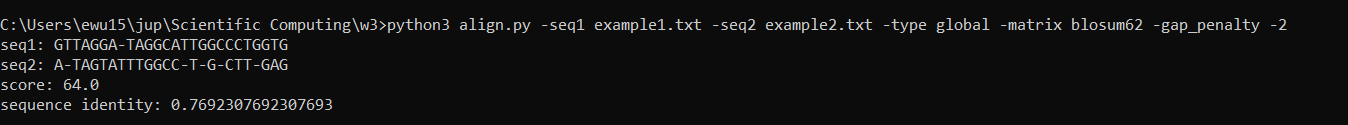

Resources and tools to help test your implementation:

* Neelemen-Wunsch 
  - A general method applicable to the search for similarities in the amino acid sequence of two proteins. Needleman SB, Wunsch CD. [J Mol Biol 1970 Mar;48(3):443-53](http://www.ncbi.nlm.nih.gov/pubmed/5420325?ordinalpos=7&itool=EntrezSystem2.PEntrez.Pubmed.Pubmed_ResultsPanel.Pubmed_DefaultReportPanel.Pubmed_RVDocSum)
  - Online Needleman-Wunsch Alignment Tool: http://rna.informatik.uni-freiburg.de/Teaching/index.jsp?toolName=Needleman-Wunsch

* Smith Waterman
  - Identification of common molecular subsequences. Smith TF, Waterman MS. [J Mol Biol 1981 Mar 25;147(1):195-7]({{site.cdn}}/2015-Autumn/Session3/dayhoff-1978-apss.pdf)
  - Online Smith Waterman Alignment Tool: http://rna.informatik.uni-freiburg.de/Teaching/index.jsp?toolName=Smith-Waterman

## 2.  Statisics of Pairwise Alignments
---------------------------------------

Perform a global sequence alignment of the following sequences:

```
PAWHEAE
HEAGAWGHEE
```
Assume a match score of `1`, a gap penalty of `3` and a substitution score of `-1`.  What is the alignment score?


In [6]:
first = "PAWHEAE"
second = "HEAGAWGHEE"
effective_matrix = {'A':{'A':1,'E':-1,'H':-1,'G':-1,'P':-1,'W':-1},
                   'E':{'A':-1,'E':1,'H':-1,'G':-1,'P':-1,'W':-1},
                   'H':{'A':-1,'E':-1,'H':1,'G':-1,'P':-1,'W':-1},
                   'G':{'A':1,'E':-1,'H':-1,'G':1,'P':-1,'W':-1},
                   'P':{'A':1,'E':-1,'H':-1,'G':-1,'P':1,'W':-1},
                    'W':{'A':1,'E':-1,'H':-1,'G':-1,'P':1,'W':1}}
find_align(first, second, "global", effective_matrix, -3)

array([[  0.,  -3.,  -6.,  -9., -12., -15., -18., -21., -24., -27., -30.],
       [ -3.,  -1.,  -4.,  -5.,  -8., -11., -14., -17., -20., -23., -26.],
       [ -6.,  -4.,  -2.,  -3.,  -6.,  -7., -10., -13., -16., -19., -22.],
       [ -9.,  -7.,  -5.,  -1.,  -4.,  -5.,  -6.,  -9., -12., -15., -18.],
       [-12.,  -8.,  -8.,  -4.,  -2.,  -5.,  -6.,  -7.,  -8., -11., -14.],
       [-15., -11.,  -7.,  -7.,  -5.,  -3.,  -6.,  -7.,  -8.,  -7., -10.],
       [-18., -14., -10.,  -6.,  -8.,  -4.,  -4.,  -7.,  -8.,  -9.,  -8.],
       [-21., -17., -13.,  -9.,  -7.,  -7.,  -5.,  -5.,  -8.,  -7.,  -8.]])

The alignment score is -8.

Next, generate 100 random sequences with the same amino acid distribution as `PAWHEAE` by. Perform an alignment of each sequence to `HEAGAWGHEE`.   Calculate the Z-score for each alignment and construct a plot using `matplotlib`. Place the Z-score on the x-axis. Include the plot inline below.

In [7]:
letters = ['P','A','W','H','E','A','E']
second = "HEAGAWGHEE"
letters = np.array(letters)
alignments = np.zeros(100)
for i in range(100):
    np.random.shuffle(letters)
    first = ""
    for letter in letters:
        first += letter
    costs = find_align(first, second, "global", effective_matrix, -3)
    alignments[i] = costs[-1][-1]
    #print(letters)
print(alignments)
# Plot here

[ -6. -12. -10. -10. -10.  -8. -12.  -6. -10.  -8. -10.  -6.  -6.  -6.
  -4.  -8.  -8. -10. -12. -10. -10. -12.  -8.  -8. -10. -10. -13.  -8.
 -10.  -6.  -4.  -8.  -6.  -6.  -8.  -6.  -8. -10. -10. -10.  -8.  -8.
 -10.  -8.  -8.  -8.  -8. -10. -10.  -8.  -8.  -8. -10.  -6. -10.  -8.
 -10. -10. -12. -10. -10. -11.  -8.  -8. -14. -10.  -6. -10.  -8.  -8.
 -10.  -6. -10.  -6. -10.  -8.  -8.  -8. -12. -10.  -8.  -6.  -8.  -8.
  -8. -10.  -8.  -6.  -8. -12.  -8.  -6. -10.  -6.  -8.  -6. -10. -10.
  -8.  -8.]


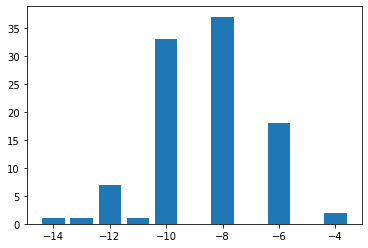

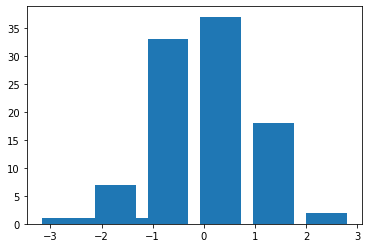

In [19]:
xs = list(set(alignments))
heights = np.zeros(len(xs))
for i in range(len(xs)):
    heights[i] = sum(alignments == xs[i])
#print(heights)
plt.bar(xs, heights)
plt.show()
zscores = scipy.stats.zscore(alignments)
xs = list(set(zscores))
heights = np.zeros(len(xs))
for i in range(len(xs)):
    heights[i] = sum(zscores == xs[i])
plt.bar(xs, heights)
plt.show()

 What does the Z-score suggest about the significance of the initial alignment your performed?  

The scores imply that the 2 amino acids are not homologous.

Are the alignment scores normally distributed?  _You can use SciPy or any other python modules to help._

In [22]:
k2, p = scipy.stats.normaltest(zscores)
print(p)

0.9405908245290449


We cannot say for certain that the scores are normally distributed here.

Repeat the process above, but now generate 1,000 and 10,000 random sequences and calculate the Z-score for each set.  Does the change in number of sequences alter your evaluation of the evolutionary relatedness of the sequences?

In [28]:
letters = ['P','A','W','H','E','A','E']
second = "HEAGAWGHEE"
letters = np.array(letters)
alignments = np.zeros(1000)
start = time.perf_counter()
for i in range(1000):
    np.random.shuffle(letters)
    first = ""
    for letter in letters:
        first += letter
    costs = find_align(first, second, "global", effective_matrix, -3)
    alignments[i] = costs[-1][-1]
end = time.perf_counter()
print(end-start)

0.6556980000004842


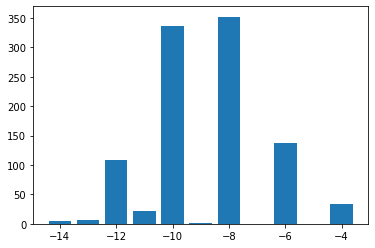

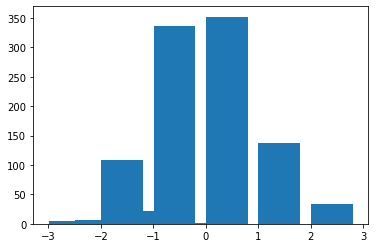

In [24]:
xs = list(set(alignments))
heights = np.zeros(len(xs))
for i in range(len(xs)):
    heights[i] = sum(alignments == xs[i])
#print(heights)
plt.bar(xs, heights)
plt.show()
zscores = scipy.stats.zscore(alignments)
xs = list(set(zscores))
heights = np.zeros(len(xs))
for i in range(len(xs)):
    heights[i] = sum(zscores == xs[i])
plt.bar(xs, heights)
plt.show()

In [29]:
letters = ['P','A','W','H','E','A','E']
second = "HEAGAWGHEE"
letters = np.array(letters)
alignments = np.zeros(10000)
start = time.perf_counter()
for i in range(10000):
    np.random.shuffle(letters)
    first = ""
    for letter in letters:
        first += letter
    costs = find_align(first, second, "global", effective_matrix, -3)
    alignments[i] = costs[-1][-1]
end = time.perf_counter()
print(end-start)

4.864585799999986


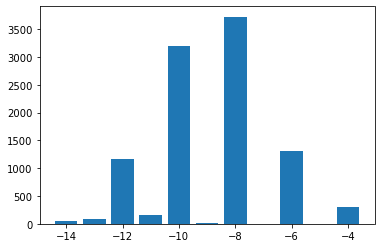

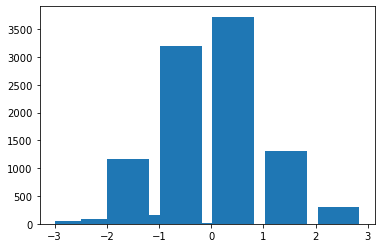

In [26]:
xs = list(set(alignments))
heights = np.zeros(len(xs))
for i in range(len(xs)):
    heights[i] = sum(alignments == xs[i])
#print(heights)
plt.bar(xs, heights)
plt.show()
zscores = scipy.stats.zscore(alignments)
xs = list(set(zscores))
heights = np.zeros(len(xs))
for i in range(len(xs)):
    heights[i] = sum(zscores == xs[i])
plt.bar(xs, heights)
plt.show()

Considering the wall time for each run, comment of the feasibility for computing the Z-score significance while searching a large database of millions of sequences.

This is not very relatistic if done frequently as while it appears to be linear with the size of the dataset, this appears to be quite slow and will only be worse for longer sequences.

# 3.  Recent Approaches in Sequence Alignemnt
-----------------------------------------------------

Search [PubMed](https://pubmed.ncbi.nlm.nih.gov) and identify a paper on a different sequence alignment method.  Do not use BLAST or FASTA.  Briefly (at a high-level), discuss what is different in these approaches and how they improve on what we have seen with Needleman-Wunch and/or Smith-Waterman.  You answer does not have to be uneccesarily technical, but please provide an understanding example of the improvement it makes. Limit your response to 1 paragragh at most. Share you findings and a link to the paper in the `#showcase` channel.